In [1]:
from PIL import Image, ImageStat
from PIL.ImageDraw import ImageDraw

import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

from random import randint
from math import pi

import os
from os import path

from fastai import vision
from fastai.vision import ImageList, FloatList, cnn_learner, pil2tensor, open_image
from fastai.callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, CSVLogger
from fastai.train import ShowGraph, Learner
from fastai.metrics import accuracy_thresh
from torchvision import models
from torch import nn
import numpy as np

from functools import partial

## Funcoes Auxiliares

In [2]:
def random_point(w, h, minx=0, miny=0):
    x, y = randint(minx, w), randint(miny, h)
    return (x, y)

def area_ellipse(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    x_len = abs(x1 - x2)
    y_len = abs(y1 - y2)
    return pi * x_len * y_len

def gen_example(w, h, num_polygons=1):
    example = Image.new('1', (w, h))
    draw = ImageDraw(example, mode='1')

    total_area = w * h
    area = 0
    for i in range(num_polygons):
        p1 = random_point(w, h)
        p2 = random_point(w, h, p1[0], p1[1])
        draw.rectangle([p1, p2], fill=1)

    (covered_area, ) = ImageStat.Stat(example).sum
    area = covered_area / total_area
    return (example, area)

def base_model(pool_layer, pool_size):
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1),
        pool_layer(pool_size),
        nn.ReLU(),
        nn.Conv2d(3, 6, 3, 1),
        pool_layer(pool_size),
        nn.ReLU(),
        nn.Conv2d(6, 4, 2, 1),
        pool_layer(pool_size),
        nn.ReLU()
    )

def cnn_max_pool(pool_size=2):
    return base_model(nn.MaxPool2d, pool_size)

class SumPool2d(nn.Module):
    def __init__(self, pool_size):
        super(SumPool2d, self).__init__()
        self.pool_size = pool_size
        self.area = pool_size * pool_size
        
    def forward(self, x):
        return F.avg_pool2d(x, self.pool_size) * self.area
    
def cnn_sum_pool(pool_size=2):
    return base_model(SumPool2d, pool_size)

def cnn_avg_pool(pool_size=2):
    return base_model(nn.AvgPool2d, pool_size)



def gen_df(root_dir, dt_len, img_size=(512, 512), skip=True, test=False):
    root_dir = path.abspath(root_dir)
    if test:
        root_dir = path.join(root_dir, 'test')
    img_dir = path.join(root_dir, 'images')
    df_dest = path.join(root_dir, 'data.csv')
    if path.exists(df_dest) and skip:
        print("Found existing dataset, skipping...")
        return pd.read_csv(df_dest, index_col=0)
    
    for directory in [root_dir, img_dir]:
        if not path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory {directory}")

    df = pd.DataFrame(columns=['filename', 'area'])
    for i in range(dt_len):
        filename = f"img_{i}.jpeg"
        dest_path = path.join(img_dir, filename)
        img, area = gen_example(*img_size)
        img.save(dest_path)
        row = pd.Series({"filename": filename, "area": area})
        df.loc[i] = row

    df.to_csv(df_dest)
    return df

def summarize_results(models, root_dir):
    df_results = pd.DataFrame()
    for model in models:
        name = model["name"]
        df_path = f"{root_dir}/{name}/history_{name}.csv"
        df = pd.read_csv(df_path, index_col=0)
        max_acc_thresh = df.iloc[df["accuracy_thresh"].idxmax()]
        max_idx = max_acc_thresh.name
        max_acc_thresh = max_acc_thresh.append(
            pd.Series({"name": name, "epoch": max_idx})
        )
        df_results = df_results.append(max_acc_thresh, ignore_index=True)

    df_results = df_results[['name', 'epoch', 'accuracy_thresh', 'valid_loss', 'train_loss']]
    df_results.to_csv(f"{root_dir}/summary")

def save_stats(learn, name):
    p = learn.recorder.plot_losses(return_fig=True)
    p.savefig(f"{learn.path}/losses")

## Dataset

In [3]:
DT_ROOT_DIR = './polygon_data'
DT_ROOT_DIR = path.abspath(DT_ROOT_DIR)
DT_LEN = 10000
W, H = 512, 512
MODEL_ROOT_DIR = "./results" 

df_train = gen_df(DT_ROOT_DIR, DT_LEN, skip=True, test=False)
df_test = gen_df(DT_ROOT_DIR, DT_LEN//2, skip=True, test=True)

Found existing dataset, skipping...
Found existing dataset, skipping...


In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class PolygonList(ImageList):
    def open(self, filename):
        return open(image)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

test_item_list = (
    ImageList
        .from_df(path=path.join(DT_ROOT_DIR, 'test', 'images'), df=df_test, convert_mode='1')
        #.split_none()
        #.label_from_df(cols=1, label_cls=FloatList)
)
    
bunch = (ImageList
            .from_df(path=path.join(DT_ROOT_DIR, 'images'), df=df_train, convert_mode='1')
            .split_by_rand_pct()
            .label_from_df(cols=1, label_cls=FloatList)
            .transform(size=(W, H))
            .add_test(test_item_list)
            .databunch(bs=4, device=device)  
        )

Device: cuda


## Model Training

In [8]:
l1 = nn.MSELoss()
loss_func = lambda i,t: l1(i.squeeze(), t)


models = [
    {"model": cnn_sum_pool, "name": "sum_pool"},
    {"model": cnn_max_pool, "name": "max_pool"},
    {"model": cnn_avg_pool, "name": "avg_pool"}
]

Epoch 6: reducing lr to 0.0006000000000000001
Epoch 11: early stopping


Epoch 17: reducing lr to 0.0006000000000000001
Epoch 22: early stopping


Epoch 6: reducing lr to 0.0006000000000000001
Epoch 14: reducing lr to 0.00012000000000000002
Epoch 22: reducing lr to 2.4000000000000004e-05
Epoch 27: early stopping


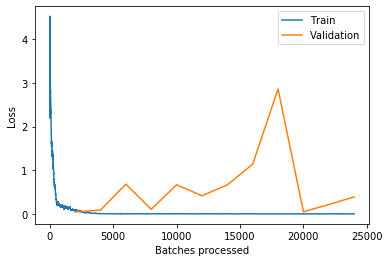

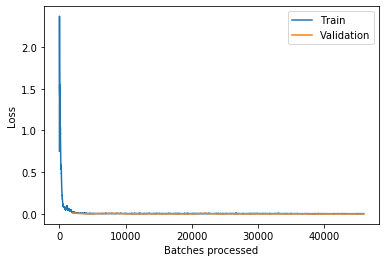

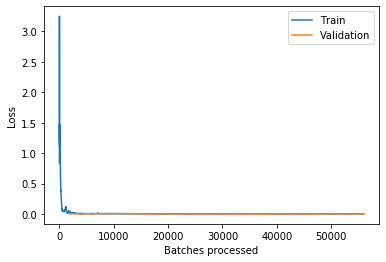

In [9]:


for model in models:
    learn = cnn_learner(
        data=bunch,
        path=f"{MODEL_ROOT_DIR}/{model['name']}",
        base_arch=lambda t: model["model"](),
        cut=lambda x: x,
        loss_func=loss_func,
        callback_fns=[
            #ShowGraph, 
            partial(EarlyStoppingCallback, patience=10), 
            partial(ReduceLROnPlateauCallback, patience=5),
            partial(CSVLogger, filename=f"history_{model['name']}")
        ],
        metrics=[
            partial(
                accuracy_thresh, 
                sigmoid=False
            )
        ],
        silent=True
    )
    learn.fit(100)
    save_stats(learn, model["name"])
    
summarize_results(models, root_dir)